In [1]:
import math
import numpy as np  
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torchvision.utils import make_grid


In [2]:
train_set= datasets.CIFAR10(root='data', 
                          download=True,
                          train= True, 
                          transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))]))
test_set= datasets.CIFAR10(root='data', 
                           download=True, 
                           train=False, 
                           transform= transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))]))

print(f"train_set length:{len(train_set)}")
print(f"test_set length:{len(test_set)}")

n_classes=10
batch_size=256

train_loader= DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader= DataLoader(test_set, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
train_set length:50000
test_set length:10000


In [3]:
def denorm(img):
    return (img/2+0.5).clamp_(0,1)
def plot_img(img_batch):
    grid= make_grid(img_batch, nrow=math.ceil(math.sqrt(batch_size)), pad_value=2)
    fig = plt.figure(figsize=(10,10))
    plt.imshow(denorm(grid).permute(1,2,0))
    plt.show()

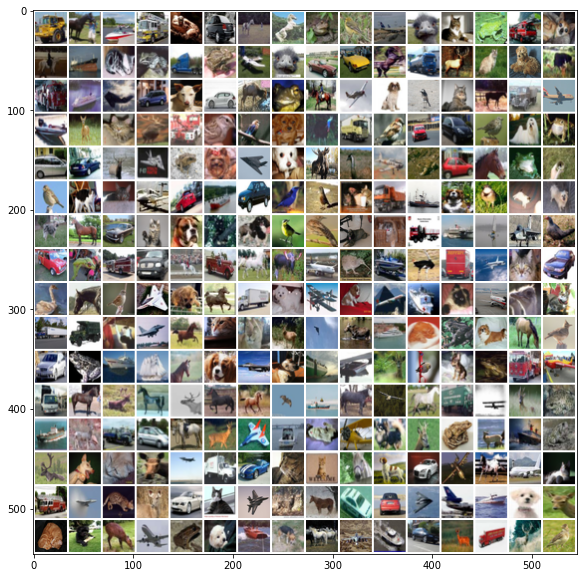

In [4]:
batch_imgs= iter(train_loader).next()[0]
plot_img(batch_imgs)

In [5]:
from models.CNN import CNN

In [6]:
def train(k, epochs):
    
    model= CNN(k, n_classes)
    opt= torch.optim.Adam(model.parameters(), lr= 1e-4)
    criterion= nn.CrossEntropyLoss()    
    
    loss_dict= {'epoch':[],'train':[], 'val':[]}
    
    for epoch in range(epochs):
        train_batch_loss=[]
        val_batch_loss=[]
        
        # train block
        for img_batch, labels_batch in train_loader:
            pred= model(img_batch)
            
            opt.zero_grad()
            loss= criterion(pred, labels_batch)
            loss.backward()
            opt.step()
            train_batch_loss.append(loss.item())
            
        #val block
        with torch.no_grad():
            for img_batch, labels_batch in val_loader:
                pred= model(img_batch)
                loss= criterion(pred, labels_batch)
                val_batch_loss.append(loss.item())
                    
        loss_dict['epoch'].append(epoch+1)
        loss_dict['train'].append(torch.tensor(train_batch_loss).mean().item())
        loss_dict['val'].append(torch.tensor(val_batch_loss).mean().item())
        
        print(",".join(["{}:{:.2f}".format(key, val[epoch]) for key, val in loss_dict.items()]))
    
    torch.save(model.state_dict(), "CNN_Cifar10{}.ckpt".format(k))
    
    return loss_dict
        
        
            


In [7]:
def plot(dd_loss_dict):
    ks= list(dd_loss_dict.keys())
    train_loss=[ dd_loss_dict[k]['train'][-1] for k in ks]
    val_loss=[ dd_loss_dict[k]['val'][-1] for k in ks]
    
    fig = plt.figure(figsize=(10,8))
    plt.plot(ks, train_loss,label='Train')
    plt.plot(ks, val_loss, label='Val')

    plt.ylabel('Cross-Entropy Loss')
    plt.xlabel('Model-Width-Parameter')
    plt.legend(fontsize=20, ncol=3) 

    plt.title('Generalisation Loss', pad=12)


In [10]:
def cnn_mdl_dd():
    width_scales=[8,16,32,64,128,256,512]
    dd_loss_dict={}
    epochs=10
    for k in width_scales:
        dd_loss_dict[k]= train(k, epochs)
    plot(dd_loss_dict)
    

In [11]:
cnn_mdl_dd()

epoch:1.00,train:2.03,val:1.81


KeyboardInterrupt: 